In [3]:
using DifferentialEquations 
using DataFrames
using Plots
using CSV
using Sundials
using JLD2
using OrdinaryDiffEq
using DelimitedFiles
using BSON
using FileIO

In [4]:
function condition(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      numerator= cellcycle[indexOfRb]+cellcycle[indexOfE2FRb]+cellcycle[indexOfpE2FRb];  #ACTIVE RB
      denominator = numerator+cellcycle[indexOfHypoPRb]; #TOTAL RB

      #GM growth (biosynthesis of ribosomes and all necessary machinery)
      #previous iterations had numerator/denominator<0.8
      #diffEq.jl requires a function that hits 0
      (numerator/denominator)-0.8
end

function affect!(integrator)
  print("r31 event to 0\n")
  #update r31Switch to 0
  integrator.u[indexOfSwitch] = 0
end

function affectNeg!(integrator)
  print("r31 event to 1\n")
  #update r31Switch to 1
  integrator.u[indexOfSwitch] = 1
end

function conditionCdh(cellcycle,t,integrator) # Event when event_f(u,t) == 0

      #triggers when Cdh1 crosses 0.2 in the positive direction
      cellcycle[indexOfCdh1]-0.2
end

## all equal function
function allequal(obj)
    local x
    isfirst = true
    for i in obj
        if isfirst
            x = i
            isfirst = false
        else
            isequal(x, i) || return false
        end
    end
    return true
end

function affectCdh!(integrator)

  #triggers when Cdh1 crosses 0.2 in the positive direction
  #update Mass to 0.5* mass

   integrator.u[indexOfMass] = 0.5*integrator.u[indexOfMass]
#   #Gm to 0.5 * Gm
   integrator.u[indexOfGM]=0.5*integrator.u[indexOfGM]
# end
# end
  if integrator.u[indexOfMass]<0.5
    #print("new switch 0 during division\n")
    integrator.u[indexNewSwitch]=0
  else
    #print("new switch 1 during division\n")
    integrator.u[indexNewSwitch]=1
  end
 
    #store the latest peak mass in the last spot and shuffle every entry down one.
    integrator.u[indexOfMassTracker5]=integrator.u[indexOfMassTracker4]
    integrator.u[indexOfMassTracker4]=integrator.u[indexOfMassTracker3]
    integrator.u[indexOfMassTracker3]=integrator.u[indexOfMassTracker2]
    integrator.u[indexOfMassTracker2]=integrator.u[indexOfMassTracker1]
    integrator.u[indexOfMassTracker1]=round(integrator.u[indexOfMass], digits=3)
    integrator.u[indexOfMassTrackerTime5]=integrator.u[indexOfMassTrackerTime4]
    integrator.u[indexOfMassTrackerTime4]=integrator.u[indexOfMassTrackerTime3]
    integrator.u[indexOfMassTrackerTime3]=integrator.u[indexOfMassTrackerTime2]
    integrator.u[indexOfMassTrackerTime2]=integrator.u[indexOfMassTrackerTime1]
    integrator.u[indexOfMassTrackerTime1]=integrator.t
    lastPeaks=[integrator.u[indexOfMassTracker5] integrator.u[indexOfMassTracker4] integrator.u[indexOfMassTracker3] integrator.u[indexOfMassTracker2] integrator.u[indexOfMassTracker1]]
    if allequal(lastPeaks)
        
       terminate!(integrator)
    end

 print("division event\n")
end

## extra functions to stop the cell cycling when mass drops below 0.5

function conditionMass(cellcycle,t,integrator) # Event when event_f(u,t) == 0
      #triggers when mass crosses 0.5
      cellcycle[indexOfMass]-0.5
end

function affectMass!(integrator)
    integrator.u[indexNewSwitch] = 1
    print("new switch 1\n")
end

function affectMassNeg!(integrator)
    integrator.u[indexNewSwitch] = 0
    print("new switch 0\n")
end

affectMassNeg! (generic function with 1 method)

In [5]:
#use the callbacks described above to trigger events
cb = ContinuousCallback(condition,affect!,affectNeg!)
cb2 = ContinuousCallback(conditionCdh,affectCdh!,nothing)
cb3 = ContinuousCallback(conditionMass,affectMass!,affectMassNeg!)
cbs=CallbackSet(cb,cb2,cb3)

CallbackSet{Tuple{ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, ContinuousCallback{typeof(conditionCdh), typeof(affectCdh!), Nothing, typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}, ContinuousCallback{typeof(conditionMass), typeof(affectMass!), typeof(affectMassNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}}, Tuple{}}((ContinuousCallback{typeof(condition), typeof(affect!), typeof(affectNeg!), typeof(SciMLBase.INITIALIZE_DEFAULT), typeof(SciMLBase.FINALIZE_DEFAULT), Float64, Int64, Rational{Int64}, Nothing, Int64}(condition, affect!, affectNeg!, SciMLBase.INITIALIZE_DEFAULT, SciMLBase.FINALIZE_DEFAULT, nothing, SciMLBase.LeftRootFind, 10, Bool[1, 1], 1, 2.220446049250313e-15, 0, 1

In [6]:
function initConditionsCellCycle(y0,syms,myc)
   #units: M 
   y0[findfirst(isequal("ERG"),syms)]=0.0121809 
   y0[findfirst(isequal("p27_cycA_Cdk2"),syms)]=0.0356927
   y0[findfirst(isequal("p27"),syms)]=0.00922806
   y0[findfirst(isequal("Cdc20"),syms)]=0.00220177 
   y0[findfirst(isequal("p27_cycE_Cdk2"),syms)]=0.000542587
   y0[findfirst(isequal("cycE"),syms)]=0.0229112 
   y0[findfirst(isequal("cycA"),syms)]=1.4094 
   y0[findfirst(isequal("cycB"),syms)]=2.72898
   y0[findfirst(isequal("p27_cycD_Cdk2"),syms)]=0.010976 
   y0[findfirst(isequal("cycD"),syms)]=0.43929 
   y0[findfirst(isequal("Cdh1"),syms)]=0.000653278 
   y0[findfirst(isequal("DRG"),syms)]=0.900533
   y0[findfirst(isequal("PPX"),syms)]=1.0
   y0[findfirst(isequal("IEP"),syms)]=0.154655
   y0[findfirst(isequal("Cdc20t"),syms)]=2.36733
   y0[findfirst(isequal("E2F_Rb"),syms)]=0.00478911
   y0[findfirst(isequal("E2F"),syms)]=0.989986
   y0[findfirst(isequal("HypoP_Rb"),syms)]=9.97574
   y0[findfirst(isequal("pE2F_Rb"),syms)]=0.0192822
   y0[findfirst(isequal("pE2F"),syms)]=3.98594
   y0[findfirst(isequal("GM"),syms)]=1.35565
   y0[findfirst(isequal("r31switch"),syms)]=1
   y0[findfirst(isequal("cMyc"),syms)]=myc
   y0[findfirst(isequal("Mass"),syms)]=1
   y0[findfirst(isequal("newSwitch"),syms)]=1
   y0[findfirst(isequal("Rb"),syms)]=0
   y0[findfirst(isequal("cMyct"),syms)]=40
   return y0
end

initConditionsCellCycle (generic function with 1 method)

### This function calculates the time point in the solution of the model at which transitions between different
### stages of the cell cycle occur.

In [7]:
### NEW FUNCTION

function Get_CC_transitions(sol_SS, time_stamp_SS)
  Cdh1_col = columnindex(sol_SS, :Cdh1)
  cycA_col = columnindex(sol_SS, :cycA)
  cycB_col = columnindex(sol_SS, :cycB)
  cycE_col = columnindex(sol_SS, :cycE)
  Mass_col = columnindex(sol_SS, :Mass)

  sol_SS_cc = sol_SS[:, [Cdh1_col,cycA_col,cycB_col,cycE_col,Mass_col]]

  # G1 -> S boundary when cycB is > 0 (or close to 0)cycB_peak_df = convert_colname(max_cycB[2])
  # S to G2 when CycE is gone but before peak in CycA
  # G2 to M at peak of CycB before rapid decrease in CycB, CycA should already be decreasing and about half way gone.

  SS_zero = convert(Int64, round(time_stamp_SS[1], digits=0))

  ##G1/S
  max_Cdh1 = findmax(sol_SS_cc[:,1])
  submax_Cdh1 = (max_Cdh1[1]/100)*95
  submax_Cdh1 = findfirst(x->x>submax_Cdh1, sol_SS_cc[:,1])
  G1S_df = sol_SS_cc[submax_Cdh1:nrow(sol_SS_cc),:]
  col_Cdh1 = G1S_df[:,1]  
  half_max_Cdh1 = max_Cdh1[1]*0.5
  G1S=findfirst(x->x<half_max_Cdh1,col_Cdh1)
  G1S_t = convert(Int64, round(time_stamp_SS[G1S+submax_Cdh1],digits=0))
  G1S_t = G1S_t - SS_zero
    
  ## S/G2
  G1St = SS_zero+G1S_t
  G1St_TS = findfirst(x->x>G1St, time_stamp_SS)
  # get max value of cycA
  colcycA = sol_SS_cc[:,2]
  max_cycA = findmax(colcycA[G1St_TS:end])
  # get time when cycA is max - 2.5%
  submaxA = (max_cycA[1]/100)*97.5
  submaxA = findfirst(x->x>submaxA,colcycA)
  SG2_t = convert(Int64, round(time_stamp_SS[submaxA],digits=0))
  SG2_t = SG2_t - SS_zero

  ## G2/M
  SG2t = SS_zero+SG2_t
  SG2t_TS = findfirst(x->x>SG2t, time_stamp_SS)
  col_cycB = sol_SS_cc[:,3]
  max_cycB = findmax(col_cycB[SG2t_TS:end])
  #submaxB = (max_cycB[1]/100)*97.5
  max_cycB = findfirst(x->x==max_cycB[1],col_cycB)
  G2M_time = convert(Int64, round(time_stamp_SS[max_cycB],digits=0))
  G2M_t = G2M_time - SS_zero

  ## M
  M_t = convert(Int64, round(time_stamp_SS[end],digits=0)) - SS_zero

  return(G1S_t,SG2_t,G2M_t,M_t)

end

Get_CC_transitions (generic function with 1 method)

In [8]:
global colnames=["G1S", "SG2", "G2M", "M"];

### Define the problem

In [17]:
### Files
reactionsFile="moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv"

## WT sim
# parametersFile="moduleDefinitionFiles/cellCycle/parameters_plus_myc.csv"
## Myc overexpression
parametersFile="moduleDefinitionFiles/cellCycle/parameters_plus_myc_mut.csv"

rateLawsFile="moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv"

### Run csv2julia
arguments=[reactionsFile, parametersFile, rateLawsFile, "odeCellCycle.jl", "scan"]
locationOfCSV2Julia="CSV2JuliaDiffEq/csv2model-multiscale.py"
cmd=`python3 $locationOfCSV2Julia $arguments`
run(cmd)

include("odeCellCycle.jl")
include("variableNames.jl")
include("scanIncludes.jl");


### Define variables
locationOfVariableNames="variableNames.jl"
include(locationOfVariableNames)
indexOfMass=findfirst(x->"Mass"==x,syms)
indexOfGM=findfirst(x->"GM"==x,syms)
indexNewSwitch=findfirst(x->"newSwitch"==x,syms)
indexOfRb=findfirst(x->"Rb"==x,syms)
indexOfE2FRb=findfirst(x->"E2F_Rb"==x,syms)
indexOfpE2FRb=findfirst(x->"pE2F_Rb"==x,syms)
indexOfHypoPRb=findfirst(x->"HypoP_Rb"==x,syms)
indexOfSwitch=findfirst(x->"r31switch"==x,syms)
indexOfCdh1=findfirst(x->"Cdh1"==x,syms)
indexOfMassTracker1=findfirst(x->"previousMass1"==x,syms)
indexOfMassTracker2=findfirst(x->"previousMass2"==x,syms)
indexOfMassTracker3=findfirst(x->"previousMass3"==x,syms)
indexOfMassTracker4=findfirst(x->"previousMass4"==x,syms)
indexOfMassTracker5=findfirst(x->"previousMass5"==x,syms)
indexOfMassTrackerTime1=findfirst(x->"previousMassTime1"==x,syms)
indexOfMassTrackerTime2=findfirst(x->"previousMassTime2"==x,syms)
indexOfMassTrackerTime3=findfirst(x->"previousMassTime3"==x,syms)
indexOfMassTrackerTime4=findfirst(x->"previousMassTime4"==x,syms)
indexOfMassTrackerTime5=findfirst(x->"previousMassTime5"==x,syms)

### Set solve conditions
syms=Symbol.(syms)

maxTimeSS=100000.0
maxTimeTC=24*60.0

DISincrease=0.000001

## set time to solve
TCLength=300*60
## set max attempts to find steady state
maximumAttemptsAtSS=20

odeFile=include("odeCellCycle.jl")
f=ODEFunction(odeFile,syms=syms)
y0=zeros(length(syms))
y0=initConditionsCellCycle(y0,String.(syms), 40)
prob=ODEProblem(f,y0,(0.0,maxTimeSS))

scan
Running CSV2JuliaDiffEq with parameters left as a function call to paramFun(n), for all params. We will also create a paramFun.jl file that should be included and defines all parameters. If this is incorrect, please re-run with 5th argument set to 'inline'
Opening moduleDefinitionFiles/cellCycle/rateLaws_plus_myc3_NS_Mass2.csv as rate law file
Opening moduleDefinitionFiles/cellCycle/parameters_plus_myc_mut.csv as parameters file
Opening moduleDefinitionFiles/cellCycle/reactions_plus_myc3_NS_Mass2.csv as reactions file
parameters can now be modified by name.
example to modify k_binding 1.5 fold higher:
modify["k_binding"]=1.5


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 100000.0)
u0: 37-element Vector{Float64}:
  0.0121809
  0.0356927
  0.00922806
  0.00220177
  0.000542587
  0.0229112
  1.4094
  2.72898
  0.010976
  0.43929
  0.000653278
  0.900533
  1.0
  ⋮
  0.0
 40.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0
  0.0

In [10]:
### solve
function solvesingle(prob)

    sol = solve(prob,callback=cbs, abstol=1e-5,reltol=1e-3,saveat=1.0)

    ### get steady state - steady state = time between peak mass values plus division (when mass drops to zero)
    sol_df = DataFrame(sol', syms)
    time_stamp = sol.t
    sol_df[!, :time_stamp] = time_stamp

    indexOfLastCycleStart=findfirst(x->x>sol[indexOfMassTrackerTime2,end],sol.t)
    sol_SS = sol_df[indexOfLastCycleStart:end, :]

    # get time stamp
    time_stamp_SS = sol_SS[:, :time_stamp]

    ### Calculate times for cell cycle transitions
    colnames=["G1S", "SG2", "G2M", "M"]
    plot_times = DataFrame(Array(collect(Get_CC_transitions(sol_SS, time_stamp_SS))'), colnames)
    
    return(sol, time_stamp_SS, plot_times, indexOfLastCycleStart)
end

solvesingle (generic function with 1 method)

In [14]:
sol_WT = solvesingle(prob);

division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event


In [15]:
sol_WT[3]

,G1S,SG2,G2M,M
,Int64,Int64,Int64,Int64
1,303,587,688,730


In [18]:
sol_Myc_mut = solvesingle(prob);

division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event
division event


In [19]:
sol_Myc_mut[3]

,G1S,SG2,G2M,M
,Int64,Int64,Int64,Int64
1,295,579,680,721


### Subset steady state

In [20]:
startOfSSIndex=sol_WT[4]
sol_WT_SS = sol_WT[1][startOfSSIndex:end]
startOfSSIndexMut=sol_Myc_mut[4]
sol_Myc_mut_SS = sol_Myc_mut[1][startOfSSIndexMut:end];

### Change timestamp

In [21]:
sol_WT_SS.t .= sol_WT_SS.t .- sol_WT_SS.t[1]
sol_Myc_mut_SS.t .= sol_Myc_mut_SS.t .- sol_Myc_mut_SS.t[1];

In [22]:
include(locationOfVariableNames)
global indexCdh1=findfirst(x->"Cdh1"==x,syms)
global indexMass=findfirst(x->"Mass"==x,syms)
global indexcycE=findfirst(x->"cycE"==x,syms)
global indexcycA=findfirst(x->"cycA"==x,syms)
global indexcycB=findfirst(x->"cycB"==x,syms)
global indexcycD=findfirst(x->"cycD"==x,syms)
global indexIEP=findfirst(x->"IEP"==x,syms)
global indexnewSwitch=findfirst(x->"newSwitch"==x,syms)
global indexmyc=findfirst(x->"cMyc"==x,syms)
global indexmyct=findfirst(x->"cMyct"==x,syms)
global indexp27=findfirst(x->"p27_cycE_Cdk2"==x,syms)

5

In [23]:
plotly()

┌ Info: For saving to png with the Plotly backend PlotlyBase has to be installed.
└ @ Plots /home/richard/.julia/packages/Plots/3E7jF/src/backends.jl:318


Plots.PlotlyBackend()

In [26]:
function plotSolSS(solSS, sol2SS, title)
    p1=plot(solSS, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexcycD,indexMass],
          lc=[:green :yellow :purple :red :blue :orange],
          lw=2.5,
          xlabel="time (hours)",
        xlims=(0,800),
        xticks=(1:300:780, string.(0:5:13)),
          legend= :outertopright,
          #ylims=(0,5),
          )   
     plot!(p1,sol2SS, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexcycD,indexMass],
          lc=[:green2 :yellow2 :purple2 :red2 :blue2 :orange2],
          legend= :outertopright,
        xlabel="time (hours)"
          ) 
end

plotSolSS (generic function with 1 method)

In [27]:
plotSolSS(sol_WT_SS, sol_Myc_mut_SS, "WT vs Myc (x1.5) cell cycle")

In [29]:
plot(sol_WT_SS, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexcycD,indexMass],
          lc=[:green :yellow :purple :red :blue :orange],
          lw=2.5,
          xlabel="time (hours)",
        xlims=(0,800),
        xticks=(1:300:780, string.(0:5:13)),
          legend= :outertopright,
          #ylims=(0,5),
          )   
vline!([309], color=:black, linestyle=:dash, lw=1, label="G1/S WT 309 mins")
vline!([592], color=:black, linestyle=:dash, lw=1.5, label="S/G2 WT 592 mins")
vline!([688], color=:black, linestyle=:dash, lw=2, label="G2/M WT 688 mins")
vline!([730], color=:black, linestyle=:dash, lw=2.5, label="M WT 730 mins")

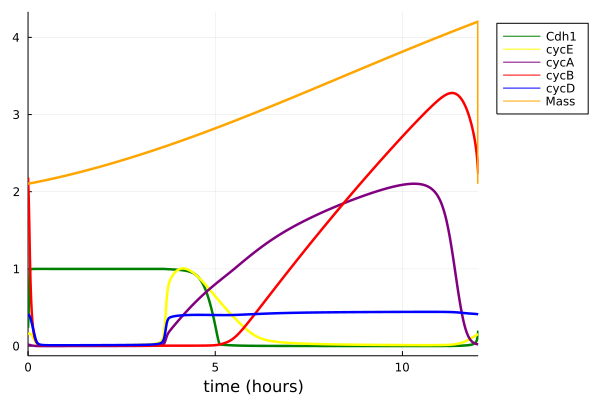

In [16]:
plot(sol_WT_SS, vars=[indexCdh1,indexcycE,indexcycA,indexcycB,indexcycD,indexMass],
          lc=[:green :yellow :purple :red :blue :orange],
          lw=2.5,
          xlabel="time (hours)",
        #xlims=(0,800),
    xticks=(sol_WT_SS.t[1]:300:sol_WT_SS.t[end], string.(0:5:13)),
          legend= :outertopright,
          #ylims=(0,5),
          #title = title,
          )   